In [1]:
import os
from keras.preprocessing import image

In [2]:
base_dir = '/tf/data'

# Directories for training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


#Directory with training coffee pictures
train_coffee_dir = os.path.join(train_dir, 'coffee')
# Directory with training noncoffee pictures
train_noncoffee_dir = os.path.join(train_dir, 'noncoffee')


# Directory with validation coffee pictures
validation_coffee_dir = os.path.join(validation_dir, 'coffee')
# Directory with validation noncoffee pictures
validation_noncoffee_dir = os.path.join(validation_dir, 'noncoffee')

# Directory with test coffee pictures
test_coffee_dir = os.path.join(test_dir, 'coffee')
# Directory with test noncoffee pictures
test_noncoffee_dir = os.path.join(test_dir, 'noncoffee')

total train coffee images: 900
total train noncoffee images: 900
total validation coffee images: 300
total validation noncoffee images: 300
total test coffee images: 238
total test noncoffee images: 238
(64, 64)


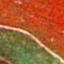

In [3]:
print('total train coffee images:', len(os.listdir(train_coffee_dir)))
print('total train noncoffee images:', len(os.listdir(train_noncoffee_dir)))
print('total validation coffee images:', len(os.listdir(validation_coffee_dir)))
print('total validation noncoffee images:', len(os.listdir(validation_noncoffee_dir)))
print('total test coffee images:', len(os.listdir(test_coffee_dir)))
print('total test noncoffee images:', len(os.listdir(test_noncoffee_dir)))

img = image.load_img(os.path.join(train_coffee_dir, os.listdir(train_coffee_dir)[0]))
print(img.size)
img.show()

It's a *balanced* binary-classification problem => classification ```accuracy``` is an appropriate measure of success.

# Preprocessing
- Read the picture files
- Decode the JPEG content to RGB grid of pixels
- Convert these into floating-point tensors
- Rescale the pixel values (between 0 and 255) to the [0,1] interval (to deal with small input values)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
# Images to tensors
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=img.size, # Resizes all images to 64x64
                batch_size=20,
                class_mode='binary') # Binary-crossentropy loss => needs
                                     # binary labels

validation_generator = test_datagen.flow_from_directory(
                validation_dir,
                target_size=img.size, # Resizes all images to 64x64
                batch_size=20,
                class_mode='binary')

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.



# First - baseline
Naively train a new small convnet on the training samples, *without regularization*, to set a baseline for what can be achieved.

In [6]:
from keras import layers
from keras import models
from tensorflow.keras import optimizers

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                    input_shape=(img.size[0], img.size[0], 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

In [15]:
history = model.fit(
                train_generator,
                # train_generator found 2400 images => images/batch_size => 1800/20 = 90
                steps_per_epoch=90,
                epochs=25,
                validation_data=validation_generator,
                # validation_generator found 600 images => images/batch_size => 600/20 = 30
                validation_steps=30)

Epoch 1/25
90/90 [==============================] - 1s 9ms/step - loss: 0.5921 - accuracy: 0.6822 - val_loss: 0.5847 - val_accuracy: 0.6933
Epoch 2/25
90/90 [==============================] - 1s 7ms/step - loss: 0.5452 - accuracy: 0.7211 - val_loss: 0.5495 - val_accuracy: 0.7267
Epoch 3/25
90/90 [==============================] - 1s 7ms/step - loss: 0.5066 - accuracy: 0.7517 - val_loss: 0.5314 - val_accuracy: 0.7250
Epoch 4/25
90/90 [==============================] - 1s 7ms/step - loss: 0.4827 - accuracy: 0.7622 - val_loss: 0.5081 - val_accuracy: 0.7333
Epoch 5/25
90/90 [==============================] - 1s 7ms/step - loss: 0.4602 - accuracy: 0.7722 - val_loss: 0.5014 - val_accuracy: 0.7433
Epoch 6/25
90/90 [==============================] - 1s 7ms/step - loss: 0.4433 - accuracy: 0.7756 - val_loss: 0.4624 - val_accuracy: 0.7567
Epoch 7/25
90/90 [==============================] - 1s 7ms/step - loss: 0.4234 - accuracy: 0.8078 - val_loss: 0.4375 - val_accuracy: 0.7800
Epoch 8/25
90/90 [==

# Plot loss and accuracy

In [10]:
import matplotlib.pyplot as plt

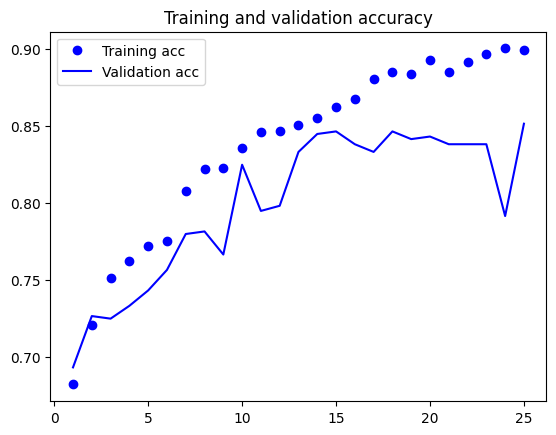

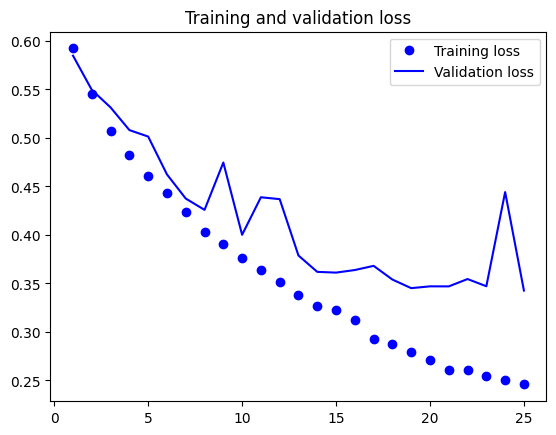

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()